In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score
import scikitplot as skplt

# Plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

# CMS data
from sodapy import Socrata
# https://dev.socrata.com/foundry/data.cms.gov/77gb-8z53

%matplotlib inline
%config InlineBackend.figure_format='retina'
hfont = {'fontname':'Helvetica'}

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [3]:
### Read in provider speciality mapping file

In [2]:
path_prov_mapping = "/Users/grahambaum/Desktop/FX/Paper_Data/"
df_prov_mapping = pd.read_csv(os.path.join(path_prov_mapping, "CMS Medicare Provider_Supplier Specialty codes.csv"), header=None)
# df_prov_mapping["1"] = "provider_spec_cd"
df_prov_mapping = df_prov_mapping.rename(columns={0: "provider_spec_cd", 1: "specialty"})
# df_imaging_total_volume_prov_rename_rad = df_imaging_total_volume_prov.copy()
df_prov_mapping.head()

,provider_spec_cd,specialty
0,1,General practice
1,2,General surgery
2,3,Allergy/immunology
3,4,Otolaryngology
4,5,Anesthesiology


### Read in place of service mapping file

# source: https://www.cms.gov/Medicare/Coding/place-of-service-codes/Place_of_Service_Code_Set

### Set up client

In [3]:
# to understand fields: https://data.cms.gov/Medicare-Physician-Supplier/Medicare-Provider-Utilization-and-Payment-Data-Phy/fs4p-t5eq
client = Socrata("data.cms.gov", None)

### Find a list of X-ray CPT codes based off description in original source

### Query new data source for volume of services for cpt list above

In [8]:
# new data: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Physician-Supplier-Procedure-Summary
year_phy_supp_db_dict = {2012: "jxyn-53mh",
                         2013: "vvf5-rctb",
                         2014: "rcv5-b2mj",
                         2015: "gwzr-e3a7",
                         2016: "7drh-2rww",
                         2017: "xfvs-efd5",
                         2018: "efgi-jnkv"}

year_phy_supp_treatment_db_dict = {2012: "jxyn-53mh",
                         2013: "vvf5-rctb",
                         2014: "rcv5-b2mj",
                         2015: "gwzr-e3a7",
                         2016: "7drh-2rww",
                         2017: "xfvs-efd5"}

In [5]:
# df_xray_codes_imaging = pd.read_csv("/Users/grahambaum/Downloads/df_xray_codes_all_years_msk_below_neck_no_chest.csv")
df_xray_codes_imaging = pd.read_csv("/Users/grahambaum/Downloads/df_xray_codes_all_years_fx_ifu.csv")

df_xray_codes_imaging["hcpcs_code"] = df_xray_codes_imaging["hcpcs_code"].astype(str)
# Create tuple of cpt codes to query on
df_xray_tuples = tuple(df_xray_codes_imaging["hcpcs_code"])
df_xray_codes_imaging

,hcpcs_code,hcpcs_description
0,73110,"X-ray of wrist, minimum of 3 views"
1,73560,"X-ray of knee, 1 or 2 views"
2,73530,X-ray of hip during surgery
3,73060,"X-ray of upper arm, minimum of 2 views"
4,73030,"X-ray of shoulder, minimum of 2 views"
5,72170,"X-ray of pelvis, 1 or 2 views"
6,73510,X-ray of hip 2 or more views
7,73564,"X-ray of knee, 4 or more views"
8,73600,"X-ray of ankle, 2 views"
9,73610,"X-ray of ankle, minimum of 3 views"


In [22]:
# Adding limit into the query or else it seems to default to 1000 rows and we would be missing data
limit_rows = 10000000
df_imaging_total_volume = pd.DataFrame()

for year in year_phy_supp_db_dict.keys():
    print(year)
    results_imaging_xray_volume = client.get(year_phy_supp_db_dict[year], where=f"hcpcs_cd IN {df_xray_tuples}",
                                 limit=limit_rows)

    df_imaging_xray_volume = pd.DataFrame.from_records(results_imaging_xray_volume)
    
    # Transform types
    df_imaging_xray_volume["psps_submitted_service_cnt"] = pd.to_numeric(df_imaging_xray_volume["psps_submitted_service_cnt"])
    df_imaging_xray_volume["psps_nch_payment_amt"] = pd.to_numeric(df_imaging_xray_volume["psps_nch_payment_amt"])
    
    ## EXCLUDE TECHNICAL COMPONENT CLAIMS (as in Mizrahi 2017)
    df_imaging_xray_volume=df_imaging_xray_volume.loc[df_imaging_xray_volume['hcpcs_initial_modifier_cd']!='TC']
    
    
    # Group by cpt code and provider type
    df_imaging_xray_volume_gr = df_imaging_xray_volume.groupby(["provider_spec_cd", "hcpcs_cd"], 
                                                          as_index=False)["psps_submitted_service_cnt",
                                                                    "psps_nch_payment_amt"].sum()
    df_imaging_xray_volume_gr["year"] = year

    # Concatenate over the years
    df_imaging_total_volume = pd.concat([df_imaging_total_volume, df_imaging_xray_volume_gr])
    
    # check if limit rows is maxed out- if so you need to increase
    if limit_rows == len(df_imaging_xray_volume):
        print("INCREASE LIMIT ROWS VARIABLE - QUERY MAXED OUT")

2012
2013
2014
2015
2016
2017
2018


In [23]:
df_imaging_xray_volume.head(20)

,hcpcs_cd,hcpcs_initial_modifier_cd,provider_spec_cd,carrier_num,pricing_locality_cd,type_of_service_cd,place_of_service_cd,hcpcs_second_modifier_cd,psps_submitted_service_cnt,psps_submitted_charge_amt,psps_allowed_charge_amt,psps_denied_services_cnt,psps_denied_charge_amt,psps_assigned_services_cnt,psps_nch_payment_amt,psps_hcpcs_asc_ind_cd,psps_error_ind_cd,hcpcs_betos_cd
0,72170,26,30,09102,04,4,21,59,175.000,7533,1493.82,20,843,175,1152.000,False,0,I1B
1,72170,RT,93,09102,99,4,20,NaN,nan,NaN,NaN,NaN,NaN,NaN,0.000,False,0,I1B
2,72170,FY,30,04412,99,4,11,NaN,nan,NaN,NaN,NaN,NaN,NaN,68.520,False,0,I1B
3,72170,FX,50,09102,99,4,20,NaN,nan,NaN,NaN,NaN,NaN,NaN,17.960,False,0,I1B
4,72170,RT,08,08102,00,4,20,NaN,nan,NaN,NaN,NaN,NaN,NaN,23.420,False,0,I1B
5,72170,26,20,00882,H8,4,11,NaN,nan,NaN,NaN,NaN,NaN,NaN,13.440,False,0,I1B
6,72170,FX,20,00882,E5,4,11,LT,nan,NaN,NaN,NaN,NaN,NaN,20.700,False,0,I1B
7,72170,26,30,07302,00,4,21,XU,nan,NaN,NaN,NaN,NaN,NaN,39.720,False,0,I1B
8,72170,FY,30,01112,07,4,11,NaN,11.000,5797,304.95,NaN,NaN,11,150.080,False,0,I1B
9,72170,26,30,00882,F8,4,11,NaN,nan,NaN,NaN,NaN,NaN,NaN,28.760,False,0,I1B


In [ ]:
# # Test volume on a specific code and year
# df_imaging_total_volume_73030 = df_imaging_total_volume.loc[(df_imaging_total_volume["hcpcs_cd"]=='73564') & (df_imaging_total_volume["year"]==2018)]
# np.sum(df_imaging_total_volume_73030["psps_submitted_service_cnt"])

In [29]:
# Save data to CSV to avoid running query in future
# df_imaging_total_volume.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_with_chest.csv", index=False)
# df_imaging_total_volume = pd.read_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_no_chest.csv")

df_imaging_total_volume.head()

,provider_spec_cd,hcpcs_cd,psps_submitted_service_cnt,psps_nch_payment_amt,year
0,01,72170,2305.000,40637.530,2012
1,01,72190,14.000,3381.910,2012
2,01,72200,11.000,701.780,2012
3,01,72202,16.000,706.490,2012
4,01,72220,93.000,6439.230,2012


In [24]:
## Calculate Total Service Counts

# 2012
df_imaging_total_volume_2012 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2012]
df_imaging_total_volume_2012.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2012=np.sum(df_imaging_total_volume_2012["psps_submitted_service_cnt"])

# 2013
df_imaging_total_volume_2013 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2013]
df_imaging_total_volume_2013.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2013=np.sum(df_imaging_total_volume_2013["psps_submitted_service_cnt"])

# 2014
df_imaging_total_volume_2014 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2014]
df_imaging_total_volume_2014.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2014=np.sum(df_imaging_total_volume_2014["psps_submitted_service_cnt"])

# 2015
df_imaging_total_volume_2015 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2015]
df_imaging_total_volume_2015.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2015=np.sum(df_imaging_total_volume_2015["psps_submitted_service_cnt"])

# 2016
df_imaging_total_volume_2016 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2016]
df_imaging_total_volume_2016.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2016=np.sum(df_imaging_total_volume_2016["psps_submitted_service_cnt"])

# 2017
df_imaging_total_volume_2017 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2017]
df_imaging_total_volume_2017.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2017=np.sum(df_imaging_total_volume_2017["psps_submitted_service_cnt"])

# 2018
df_imaging_total_volume_2018 = df_imaging_total_volume.loc[df_imaging_total_volume["year"]==2018]
df_imaging_total_volume_2018.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
total_volume_2018=np.sum(df_imaging_total_volume_2018["psps_submitted_service_cnt"])

df_total_volume = pd.DataFrame({'year':[2012, 2013, 2014, 2015, 2016, 2017, 2018],'total_volume':[total_volume_2012, total_volume_2013, total_volume_2014, total_volume_2015, total_volume_2016, total_volume_2017, total_volume_2018]})

df_total_volume

,year,total_volume
0,2012,18764843.000
1,2013,18967389.700
2,2014,19448064.700
3,2015,19714450.900
4,2016,18909773.900
5,2017,18832011.500
6,2018,18847221.300


In [28]:
## Create Table with # Medicare Enrollees for Utilization Rate

df_medicare_enrollment = pd.DataFrame({'year':[2012, 2013, 2014, 2015, 2016, 2017, 2018],'medicare_enrollment':[37213622, 37613096, 37790373, 38025274, 38610384, 38667830, 38665082]})

df_medicare_enrollment['denom']=df_medicare_enrollment['medicare_enrollment']/1000
df_medicare_enrollment

,year,medicare_enrollment,denom
0,2012,37213622,37213.622
1,2013,37613096,37613.096
2,2014,37790373,37790.373
3,2015,38025274,38025.274
4,2016,38610384,38610.384
5,2017,38667830,38667.830
6,2018,38665082,38665.082


In [29]:
# Merge in provider speciality
df_imaging_total_volume_prov = df_imaging_total_volume.groupby(["provider_spec_cd", "year"],
                                                              as_index=False)["psps_submitted_service_cnt", "psps_nch_payment_amt"].sum()
df_imaging_total_volume_prov = df_imaging_total_volume_prov.merge(df_prov_mapping, on = "provider_spec_cd", how="inner")

# df_imaging_total_volume_prov.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_prov_no_chest_FX_IFU.csv", index=False)

df_imaging_total_volume_prov.head()


,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty
0,10,2012,369.000,17707.650,Gastroenterology
1,10,2013,228.000,12872.120,Gastroenterology
2,10,2014,87.000,9241.380,Gastroenterology
3,10,2015,100.000,8297.210,Gastroenterology
4,10,2016,136.000,8915.880,Gastroenterology


In [11]:
df_imaging_total_volume_prov=pd.read_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_prov_no_chest_FX_IFU.csv")
df_imaging_total_volume_prov

,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty
0,10,2012,549.000,23026.710,Gastroenterology
1,10,2013,343.000,17353.040,Gastroenterology
2,10,2014,186.000,13013.320,Gastroenterology
3,10,2015,198.000,10763.400,Gastroenterology
4,10,2016,196.000,11865.190,Gastroenterology
5,10,2017,185.000,13068.570,Gastroenterology
6,10,2018,294.000,12650.200,Gastroenterology
7,11,2012,237763.000,5704082.170,Internal medicine
8,11,2013,231507.000,5620666.240,Internal medicine
9,11,2014,230093.000,5235865.350,Internal medicine


In [ ]:
###################
## CMS Line Plot ##
###################
df_cms_bar = pd.read_csv("/Users/grahambaum/Desktop/CMS_Utilization_2012_to_2018.csv")

df_cms_bar["Year"] = pd.to_numeric(df_cms_bar["Year"])
df_cms_bar["Utilization"] = pd.to_numeric(df_cms_bar["Utilization"])
df_cms_bar["Perc_Change"] = pd.to_numeric(df_cms_bar["Perc_Change"])


fig, ax = plt.subplots(1,1, figsize=(7,5))
df_cms_bar.sort_values(by="Perc_Change", ascending=False, inplace=True)
sns.lineplot(x="Year", y="Perc_Change", style="Specialty", hue="Specialty", data = df_cms_bar,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change in Utilization Rate")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")

In [ ]:
df_cms_bar = pd.read_csv("/Users/grahambaum/Desktop/CMS_Utilization_2012_to_2018.csv")
df_cms_bar

In [ ]:
### Volume grouping - Specialists, General Practice, Emergency Medicine

In [30]:
df_imaging_total_volume_prov_2018 = df_imaging_total_volume_prov.loc[df_imaging_total_volume_prov["year"]==2018]
df_imaging_total_volume_prov_2018.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
df_imaging_total_volume_prov_2018.head(10)
np.sum(df_imaging_total_volume_prov_2018["psps_submitted_service_cnt"])

18528031.3

In [ ]:
np.unique(df_imaging_total_volume_prov_2018.specialty)

In [ ]:
df_imaging_total_volume_prov_2017.loc[df_imaging_total_volume_prov_2017["provider_spec_cd"] == 8]

np.unique(df_imaging_total_volume_prov.specialty)

In [31]:
# pull out radiology and ortho
rad_list = ["Diagnostic radiology"]#list(df_prov_mapping.loc[df_prov_mapping["speciality"].str.contains("radiology")]["speciality"])
ortho_list = ["Orthopedic surgery"] #list(df_prov_mapping.loc[df_prov_mapping["speciality"].str.contains("Orthopedic")]["speciality"])
# general_prac_list = ["Internal medicine", "Family practice", "General practice"] #,  "Osteopathic manipulative medicine","Hospice and palliative care"]


primary_care_list = ["Internal medicine", "Family practice"] #,  "General practice","Osteopathic manipulative medicine","Hospice and palliative care"]

emergency_list = ["Emergency medicine"]
pa_list=["Physician assistant"]

nonphysician_list = ["Physician assistant", "Nurse practitioner"] #, "Chiropractic"]

podiatry_list= ["Podiatry"]
handSurgery_list= ["Hand surgery"]

specialist_list = ["Diagnostic radiology", "Orthopedic surgery"]
nonspecialist_list = ["Internal medicine", "Family practice", "General practice", "Osteopathic manipulative medicine",
                    "Hospice and palliative care", "Nurse practitioner", "Physician assistant"]

FX_nonphysician_list = ["Internal medicine", "Family practice", "General practice",  "Physician assistant"]

all_prov_list=np.unique(df_imaging_total_volume_prov.specialty)
all_prov_list

# df_imaging_total_volume_prov.specialty("Ambulatory surgical center")
# df_test = df_imaging_total_volume_prov.loc[df_imaging_total_volume_prov["specialty"].isin(speciality_list)]

array(['Addiction medicine', 'Ambulance service (private)',
       'Ambulatory surgical center',
       'Audiologist (billing independently)', 'Cardiac electrophysiology',
       'Cardiac surgery', 'Certified clinical nurse specialist',
       'Certified nurse midwife',
       'Certified registered nurse anesthetist (CRNA)', 'Chiropractic',
       'Clinical laboratory (billing independently)',
       'Clinical psychologist',
       'Colorectal surgery (formerly proctology)',
       'Critical care (intensivists)', 'Diagnostic radiology',
       'Emergency medicine', 'Endocrinology', 'Gastroenterology',
       'Geriatric medicine', 'Gynecological/oncology', 'Hand surgery',
       'Hematology', 'Hematology/oncology', 'Hospice and palliative care',
       'Hospital', 'Hospitalist',
       'Independent diagnostic testing facility', 'Infectious disease',
       'Internal medicine', 'Interventional cardiology',
       'Interventional radiology', 'Licensed clinical social worker',
       'Mamm

In [ ]:
# Find grouping % change and % change y/o/y

In [33]:
def perc_change(df, speciality_list, base_year):
    df_group = df.loc[df["specialty"].isin(speciality_list)]
    df_group.reset_index(drop=True, inplace=True)
    df_group.sort_values(by="year", inplace=True)
    val_base = float(df_group.loc[df_group["year"] == base_year]["psps_submitted_service_cnt"])
    df_group["% change y/o/y"] = 100*df_group["psps_submitted_service_cnt"].pct_change()
    df_group["% change"] = None
    for i in range(len(df_group)):
        df_group["% change"].iloc[i] = 100 * (df_group["psps_submitted_service_cnt"].iloc[i] - val_base)/val_base
    
    return df_group

In [34]:
def perc_change_utilization(df, speciality_list, base_year):
    df_group = df.loc[df["specialty"].isin(speciality_list)]
    df_group.reset_index(drop=True, inplace=True)
    df_group.sort_values(by="year", inplace=True)
    val_base = float(df_group.loc[df_group["year"] == base_year]["utilization"])
    df_group["% change y/o/y"] = 100*df_group["utilization"].pct_change()
    df_group["% change"] = None
    for i in range(len(df_group)):
        df_group["% change"].iloc[i] = 100 * (df_group["utilization"].iloc[i] - val_base)/val_base
    
    return df_group

In [32]:
## ALL PROVIDERS
df_imaging_total_volume_prov_rename_allProv = df_imaging_total_volume_prov.copy()
for spec in all_prov_list:
    df_imaging_total_volume_prov_rename_allProv.replace(spec, "All Providers", inplace=True)
df_imaging_total_volume_prov_rename_allProv = df_imaging_total_volume_prov_rename_allProv.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_allProv = perc_change(df_imaging_total_volume_prov_rename_allProv, ["All Providers"], 2012)
df_imaging_total_volume_prov_allProv

df_volume_total = df_imaging_total_volume_prov_allProv
# df_volume_total = df_volume_total.loc[df_volume_total["year"]<2018]
df_volume_total["year"] = pd.to_numeric(df_volume_total["year"])
df_volume_total["% change"] = pd.to_numeric(df_volume_total["% change"])
df_volume_total.head()

fig, ax = plt.subplots(1,1, figsize=(7,5))
df_volume_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_volume_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))

NameError: name 'perc_change' is not defined

In [ ]:
df_imaging_total_volume_prov_rename_allProv

####################################
## Analyse 2018 for All Providers ##
####################################

df_volume_total_2018 = df_imaging_total_volume_prov_rename_allProv.loc[df_imaging_total_volume_prov_rename_allProv["year"]==2018]
df_volume_total_2018.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
df_volume_total_2018.head(10)

In [59]:
# Radiologists
df_imaging_total_volume_prov_rename_rad = df_imaging_total_volume_prov.copy()
df_imaging_total_volume_prov_rename_rad.replace("Diagnostic radiology", "Radiologist", inplace=True)

df_imaging_total_volume_prov_rad = perc_change(df_imaging_total_volume_prov_rename_rad, ["Radiologist"], 2012)

df_imaging_total_volume_prov_rad['service_proportion'] =  (df_imaging_total_volume_prov_rad['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100
df_imaging_total_volume_prov_rad['utilization'] =  (df_imaging_total_volume_prov_rad['psps_submitted_service_cnt'] / df_medicare_enrollment['denom']) 
# df_imaging_total_volume_prov_rad = perc_change(df_imaging_total_volume_prov_rad, ["Radiologist"], 2012)

df_imaging_total_volume_prov_rad

## TEST
df_imaging_total_volume_prov_rad = perc_change_utilization(df_imaging_total_volume_prov_rad, ["Radiologist"], 2012)
df_imaging_total_volume_prov_rad

,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty,% change y/o/y,% change,service_proportion,utilization
0,30,2012,9790869.500,88326313.270,Radiologist,nan,0.000,52.177,263.099
1,30,2013,9893395.100,87813107.330,Radiologist,-0.026,-0.026,52.160,263.031
2,30,2014,10174378.400,91576398.760,Radiologist,2.358,2.331,52.316,269.232
3,30,2015,10391051.500,90702423.400,Radiologist,1.499,3.865,52.708,273.267
4,30,2016,9993301.800,87192352.750,Radiologist,-5.285,-1.625,52.847,258.824
5,30,2017,10065238.100,87787796.750,Radiologist,0.570,-1.064,53.447,260.300
6,30,2018,10112719.000,89398541.110,Radiologist,0.479,-0.590,53.656,261.547


In [57]:
# Ortho
df_imaging_total_volume_prov_ortho = perc_change(df_imaging_total_volume_prov, ortho_list, 2012)
df_imaging_total_volume_prov_ortho

## Rename
df_imaging_total_volume_prov_ortho.replace("Orthopedic surgery", "Orthopedic Surgeon", inplace=True)


df_imaging_total_volume_prov_ortho['service_proportion'] =  (df_imaging_total_volume_prov_ortho['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100
df_imaging_total_volume_prov_ortho['utilization'] =  (df_imaging_total_volume_prov_ortho['psps_submitted_service_cnt'] / df_medicare_enrollment['denom'])

df_imaging_total_volume_prov_ortho

## TEST
df_imaging_total_volume_prov_ortho = perc_change_utilization(df_imaging_total_volume_prov_ortho, ["Orthopedic Surgeon"], 2012)
df_imaging_total_volume_prov_ortho


,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty,% change y/o/y,% change,service_proportion,utilization
0,20,2012,6224212.200,141170675.250,Orthopedic Surgeon,nan,0.000,33.170,167.256
1,20,2013,6245385.900,143647407.940,Orthopedic Surgeon,-0.725,-0.725,32.927,166.043
2,20,2014,6325989.300,140562994.840,Orthopedic Surgeon,0.815,0.084,32.528,167.397
3,20,2015,6285312.100,129591667.000,Orthopedic Surgeon,-1.257,-1.174,31.882,165.293
4,20,2016,5879996.000,128308126.140,Orthopedic Surgeon,-7.866,-8.948,31.095,152.291
5,20,2017,5730555.300,126627544.510,Orthopedic Surgeon,-2.686,-11.394,30.430,148.200
6,20,2018,5631137.500,125712207.020,Orthopedic Surgeon,-1.728,-12.925,29.878,145.639


In [56]:
# ER
df_imaging_total_volume_prov_emer = perc_change(df_imaging_total_volume_prov, emergency_list, 2012)


df_imaging_total_volume_prov_emer['service_proportion'] =  (df_imaging_total_volume_prov_emer['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100
df_imaging_total_volume_prov_emer['utilization'] =  (df_imaging_total_volume_prov_emer['psps_submitted_service_cnt'] / df_medicare_enrollment['denom'])

df_imaging_total_volume_prov_emer

## TEST
df_imaging_total_volume_prov_emer = perc_change_utilization(df_imaging_total_volume_prov_emer, ["Emergency medicine"], 2012)
df_imaging_total_volume_prov_emer

,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty,% change y/o/y,% change,service_proportion,utilization
0,93,2012,103370.000,1719635.140,Emergency medicine,nan,0.000,0.551,2.778
1,93,2013,103312.000,1783650.980,Emergency medicine,-1.118,-1.118,0.545,2.747
2,93,2014,104699.000,1900638.280,Emergency medicine,0.867,-0.260,0.538,2.771
3,93,2015,100350.000,1751821.960,Emergency medicine,-4.746,-4.994,0.509,2.639
4,93,2016,91623.500,1743298.440,Emergency medicine,-10.080,-14.570,0.485,2.373
5,93,2017,89702.000,1695184.070,Emergency medicine,-2.243,-16.486,0.476,2.320
6,93,2018,80451.000,1557146.100,Emergency medicine,-10.307,-25.093,0.427,2.081


In [47]:
test= df_imaging_total_volume_prov.loc[df_imaging_total_volume_prov['specialty']=="General practice"]
test

,provider_spec_cd,year,psps_submitted_service_cnt,psps_nch_payment_amt,specialty


In [48]:
# Primary Care 
df_imaging_total_volume_prov_rename_gp = df_imaging_total_volume_prov.copy()
for spec in primary_care_list:
    df_imaging_total_volume_prov_rename_gp.replace(spec, "Primary Care", inplace=True)
df_imaging_total_volume_prov_rename_gp = df_imaging_total_volume_prov_rename_gp.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_gp = perc_change(df_imaging_total_volume_prov_rename_gp, ["Primary Care"], 2012)

df_imaging_total_volume_prov_gp['service_proportion'] =  (df_imaging_total_volume_prov_gp['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100
df_imaging_total_volume_prov_gp['utilization'] =  (df_imaging_total_volume_prov_gp['psps_submitted_service_cnt'] / df_medicare_enrollment['denom'])

df_imaging_total_volume_prov_gp

## TEST
df_imaging_total_volume_prov_rename_gp= df_imaging_total_volume_prov_gp
df_imaging_total_volume_prov_gp = perc_change_utilization(df_imaging_total_volume_prov_rename_gp, ["Primary Care"], 2012)
df_imaging_total_volume_prov_gp


,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change,service_proportion,utilization
0,2012,Primary Care,159730.000,nan,0.000,0.851,4.292
1,2013,Primary Care,152177.000,-5.740,-5.740,0.802,4.046
2,2014,Primary Care,147520.000,-3.515,-9.054,0.759,3.904
3,2015,Primary Care,133578.000,-10.010,-18.158,0.678,3.513
4,2016,Primary Care,128794.000,-5.043,-22.285,0.681,3.336
5,2017,Primary Care,114727.000,-11.054,-30.876,0.609,2.967
6,2018,Primary Care,101116.000,-11.858,-39.072,0.537,2.615


In [49]:
# Physician Assistants
df_imaging_total_volume_prov_rename_pa = df_imaging_total_volume_prov.copy()
for spec in pa_list:
    df_imaging_total_volume_prov_rename_pa.replace(spec, "Physician Assistant", inplace=True)
df_imaging_total_volume_prov_rename_pa_gr = df_imaging_total_volume_prov_rename_pa.groupby(["year", "specialty"], 
                                                                                                     as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_pa = perc_change(df_imaging_total_volume_prov_rename_pa_gr, ["Physician Assistant"], 2012)

df_imaging_total_volume_prov_pa['service_proportion'] =  (df_imaging_total_volume_prov_pa['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100
df_imaging_total_volume_prov_pa['utilization'] =  (df_imaging_total_volume_prov_pa['psps_submitted_service_cnt'] / df_medicare_enrollment['denom'])

## TEST
df_imaging_total_volume_prov_rename_pa_gr = df_imaging_total_volume_prov_pa
df_imaging_total_volume_prov_pa = perc_change_utilization(df_imaging_total_volume_prov_rename_pa_gr, ["Physician Assistant"], 2012)
df_imaging_total_volume_prov_pa

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change,service_proportion,utilization
0,2012,Physician Assistant,425358.000,nan,0.000,2.267,11.430
1,2013,Physician Assistant,496558.000,15.499,15.499,2.618,13.202
2,2014,Physician Assistant,569535.000,14.159,31.852,2.928,15.071
3,2015,Physician Assistant,643819.000,12.345,48.129,3.266,16.931
4,2016,Physician Assistant,685737.000,4.897,55.382,3.626,17.760
5,2017,Physician Assistant,752789.000,9.615,70.322,3.997,19.468
6,2018,Physician Assistant,836427.000,11.118,89.259,4.438,21.633


In [50]:
# Non-physicians
df_imaging_total_volume_prov_rename_non_phy = df_imaging_total_volume_prov.copy()
for spec in nonphysician_list:
    df_imaging_total_volume_prov_rename_non_phy.replace(spec, "Non-Physician", inplace=True)
df_imaging_total_volume_prov_rename_non_phy_gr = df_imaging_total_volume_prov_rename_non_phy.groupby(["year", "specialty"], 
                                                                                                     as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_non_phy = perc_change(df_imaging_total_volume_prov_rename_non_phy_gr, ["Non-Physician"], 2012)

df_imaging_total_volume_prov_non_phy['service_proportion'] =  (df_imaging_total_volume_prov_non_phy['psps_submitted_service_cnt'] / df_total_volume['total_volume']) * 100

df_imaging_total_volume_prov_non_phy

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change,service_proportion
0,2012,Non-Physician,500313.500,nan,0.000,2.666
1,2013,Non-Physician,588524.000,17.631,17.631,3.103
2,2014,Non-Physician,682559.000,15.978,36.426,3.510
3,2015,Non-Physician,777512.000,13.911,55.405,3.944
4,2016,Non-Physician,834494.900,7.329,66.794,4.413
5,2017,Non-Physician,927226.100,11.112,85.329,4.924
6,2018,Non-Physician,1036183.000,11.751,107.107,5.498


In [51]:
# Specialists (Radiologists + Orthopedists)
df_imaging_total_volume_prov_rename_spec = df_imaging_total_volume_prov.copy()
for spec in specialist_list:
    df_imaging_total_volume_prov_rename_spec.replace(spec, "Specialist", inplace=True)
df_imaging_total_volume_prov_rename_spec = df_imaging_total_volume_prov_rename_spec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_spec = perc_change(df_imaging_total_volume_prov_rename_spec, ["Specialist"], 2012)
df_imaging_total_volume_prov_spec

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change
0,2012,Specialist,16015081.700,nan,0.000
1,2013,Specialist,16138781.000,0.772,0.772
2,2014,Specialist,16500367.700,2.240,3.030
3,2015,Specialist,16676363.600,1.067,4.129
4,2016,Specialist,15873297.800,-4.816,-0.885
5,2017,Specialist,15795793.400,-0.488,-1.369
6,2018,Specialist,15743856.500,-0.329,-1.694


In [52]:
# Non-specialists
df_imaging_total_volume_prov_rename_nonspec = df_imaging_total_volume_prov.copy()
for spec in nonspecialist_list:
    df_imaging_total_volume_prov_rename_nonspec.replace(spec, "Non-Specialist", inplace=True)
df_imaging_total_volume_prov_rename_nonspec = df_imaging_total_volume_prov_rename_nonspec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_nonspec = perc_change(df_imaging_total_volume_prov_rename_nonspec, ["Non-Specialist"], 2012)
df_imaging_total_volume_prov_nonspec

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change
0,2012,Non-Specialist,665494.500,nan,0.000
1,2013,Non-Specialist,744077.000,11.808,11.808
2,2014,Non-Specialist,834815.000,12.195,25.443
3,2015,Non-Specialist,916591.000,9.796,37.731
4,2016,Non-Specialist,969927.900,5.819,45.745
5,2017,Non-Specialist,1048563.100,8.107,57.561
6,2018,Non-Specialist,1143956.000,9.097,71.896


In [53]:
# Podiatrists
df_imaging_total_volume_prov_rename_pod = df_imaging_total_volume_prov.copy()
for spec in podiatry_list:
    df_imaging_total_volume_prov_rename_pod.replace(spec, "Podiatry", inplace=True)
df_imaging_total_volume_prov_rename_pod = df_imaging_total_volume_prov_rename_pod.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_pod = perc_change(df_imaging_total_volume_prov_rename_pod, ["Podiatry"], 2012)
df_imaging_total_volume_prov_pod

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change
0,2012,Podiatry,128093.000,nan,0.000
1,2013,Podiatry,133512.000,4.231,4.231
2,2014,Podiatry,143808.000,7.712,12.268
3,2015,Podiatry,149954.000,4.274,17.067
4,2016,Podiatry,153481.100,2.352,19.820
5,2017,Podiatry,159331.000,3.811,24.387
6,2018,Podiatry,165656.000,3.970,29.325


In [54]:
# Hand Surgeons
df_imaging_total_volume_prov_rename_handSurg = df_imaging_total_volume_prov.copy()
for spec in handSurgery_list:
    df_imaging_total_volume_prov_rename_handSurg.replace(spec, "Hand surgery", inplace=True)
df_imaging_total_volume_prov_rename_handSurg = df_imaging_total_volume_prov_rename_handSurg.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_imaging_total_volume_prov_handSurg = perc_change(df_imaging_total_volume_prov_rename_handSurg, ["Hand surgery"], 2012)
df_imaging_total_volume_prov_handSurg

,year,specialty,psps_submitted_service_cnt,% change y/o/y,% change
0,2012,Hand surgery,134560.000,nan,0.000
1,2013,Hand surgery,143313.000,6.505,6.505
2,2014,Hand surgery,158157.000,10.358,17.536
3,2015,Hand surgery,173025.200,9.401,28.586
4,2016,Hand surgery,183654.100,6.143,36.485
5,2017,Hand surgery,194291.000,5.792,44.390
6,2018,Hand surgery,199560.000,2.712,48.306


### Plots

In [ ]:
## Specialist vs. Non-Specialist Plots
df_volume_total = pd.concat([df_imaging_total_volume_prov_spec,
                            df_imaging_total_volume_prov_nonspec])
# df_volume_total = df_volume_total.loc[df_volume_total["year"]<2018]
df_volume_total["year"] = pd.to_numeric(df_volume_total["year"])
df_volume_total["% change"] = pd.to_numeric(df_volume_total["% change"])
df_volume_total.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_Spec_Nonspec_Plot.csv")
df_volume_total

Text(0.5, 1.0, 'CMS Physician/Supplier Procedure X-ray Imaging Volume')

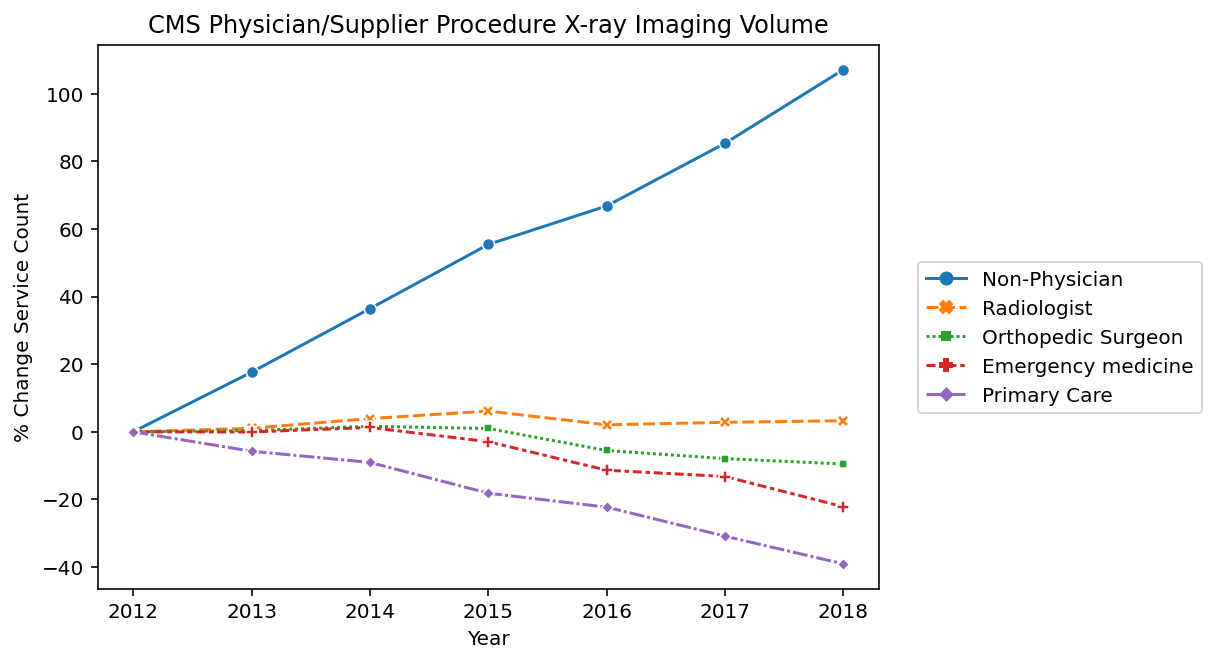

In [55]:
## Original Provider Groupings
# df_volume_total = pd.concat([df_imaging_total_volume_prov_rad,
#                             df_imaging_total_volume_prov_ortho,
#                             df_imaging_total_volume_prov_emer,
#                            df_imaging_total_volume_prov_gp,
#                            df_imaging_total_volume_prov_non_phy])

df_volume_total = pd.concat([df_imaging_total_volume_prov_rad,
                            df_imaging_total_volume_prov_ortho,
                            df_imaging_total_volume_prov_emer,
                           df_imaging_total_volume_prov_gp,
                            df_imaging_total_volume_prov_non_phy])
# df_volume_total = df_volume_total.loc[df_volume_total["year"]<2018]
df_volume_total["year"] = pd.to_numeric(df_volume_total["year"])
df_volume_total["% change"] = pd.to_numeric(df_volume_total["% change"])


fig, ax = plt.subplots(1,1, figsize=(7,5))
df_volume_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_volume_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))

In [ ]:
df_volume_total.head()

In [ ]:
df_volume_total.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_total_volume_Plot")
df_volume_total

In [ ]:
## Analyse 2018 Only ##
#######################

df_volume_total_2018 = df_volume_total.loc[df_volume_total["year"]==2018]
df_volume_total_2018.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
df_volume_total_2018.head(10)
df_volume_total_2018.

In [ ]:
df_total_volume_2018=

In [ ]:
## Specialist vs. Non-Specialist Plots
df_volume_total = pd.concat([df_imaging_total_volume_prov_spec,
                            df_imaging_total_volume_prov_nonspec,
                            df_imaging_total_volume_prov_pod,
                            df_imaging_total_volume_prov_handSurg])
# df_volume_total = df_volume_total.loc[df_volume_total["year"]<2018]
df_volume_total["year"] = pd.to_numeric(df_volume_total["year"])
df_volume_total["% change"] = pd.to_numeric(df_volume_total["% change"])
df_volume_total.head()

fig, ax = plt.subplots(1,1, figsize=(7,5))
df_volume_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_volume_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))
df_volume_total.columns

In [ ]:
## Specialist vs. Non-Specialist Plots
df_volume_total = pd.concat([df_imaging_total_volume_prov_spec,
                            df_imaging_total_volume_prov_nonspec,
                            df_imaging_total_volume_prov_pod,
                            df_imaging_total_volume_prov_handSurg])
df_volume_total = df_volume_total.loc[df_volume_total["year"]<2018]
df_volume_total["year"] = pd.to_numeric(df_volume_total["year"])
df_volume_total["psps_submitted_service_cnt"] = pd.to_numeric(df_volume_total["psps_submitted_service_cnt"])
df_volume_total.head()

fig, ax = plt.subplots(1,1, figsize=(7,5))
df_volume_total.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
sns.lineplot(x="year", y="psps_submitted_service_cnt", style="specialty", hue="specialty", data = df_volume_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("PSPS Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))
df_volume_total.columns

In [ ]:


fig, ax = plt.subplots(1,1, figsize=(7,5))
df_volume_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_volume_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure X-ray Imaging Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))
df_volume_total.columns

In [ ]:
df_volume_total_2017_order = df_volume_total.loc[df_volume_total["year"]==2017][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_volume_total_2017_order

In [ ]:
df_volume_total_2018_order = df_volume_total.loc[df_volume_total["year"]==2018][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_volume_total_2018_order

### Find a list of Fracture Treatment CPT codes based off description in original source

In [ ]:
# Adding limit into the query or else it seems to default to 1000 rows and we would be missing data
limit_rows = 10000000 

results_frac_treatment = client.get("hczc-ufy5", where=f"hcpcs_description like '%fracture%' or hcpcs_description like '%broken%'",
                             limit=limit_rows)

df_fracture_treatment = pd.DataFrame.from_records(results_frac_treatment)
# Transform types
df_fracture_treatment["line_srvc_cnt"] = pd.to_numeric(df_fracture_treatment["line_srvc_cnt"])

# check if limit rows is maxed out- if so you need to increase
if limit_rows == len(df_fracture_treatment):
    print("INCREASE LIMIT ROWS VARIABLE - QUERY MAXED OUT")

In [ ]:
df_fracture_treat_codes = df_fracture_treatment[["hcpcs_code", "hcpcs_description"]].drop_duplicates()
df_fracture_treat_codes = tuple(df_fracture_treat_codes["hcpcs_code"])
# df_fracture_treat_codes.to_csv("~/Desktop/df_fracture_treat_codes.csv", index=False)
# also compare cpt code output to this source: https://www.radiologybillingcoding.com/x-ray-cpt-code-list

In [ ]:
# Adding limit into the query or else it seems to default to 1000 rows and we would be missing data
limit_rows = 100000000
df_treatment_total_volume = pd.DataFrame()

for year in year_phy_supp_treatment_db_dict.keys():
    print(year)
    results_treatment_volume = client.get(year_phy_supp_db_dict[year], where=f"hcpcs_cd IN {df_fracture_treat_codes}",
                                 limit=limit_rows)

    df_treatment_volume = pd.DataFrame.from_records(results_treatment_volume)
    # Transform types
    df_treatment_volume["psps_submitted_service_cnt"] = pd.to_numeric(df_treatment_volume["psps_submitted_service_cnt"])
    df_treatment_volume["psps_nch_payment_amt"] = pd.to_numeric(df_treatment_volume["psps_nch_payment_amt"])
    
    # Group by cpt code and provider type
    df_treatment_volume_gr = df_treatment_volume.groupby(["provider_spec_cd", "hcpcs_cd"], 
                                                          as_index=False)["psps_submitted_service_cnt",
                                                                         "psps_nch_payment_amt"].sum()
    df_treatment_volume["year"] = year

    # Concatenate over the years
    df_treatment_total_volume = pd.concat([df_treatment_total_volume, df_treatment_volume])
    
    # check if limit rows is maxed out- if so you need to increase
    if limit_rows == len(df_treatment_volume):
        print("INCREASE LIMIT ROWS VARIABLE - QUERY MAXED OUT")

In [ ]:
# Save data to CSV to avoid running query in future
df_treatment_total_volume.to_csv("/Users/grahambaum/Desktop/FX/CMS_Analysis/df_treatment_total_volume_pay.csv", index=False)

In [ ]:
# Merge in provider speciality
df_treatment_total_volume_prov = df_treatment_total_volume.groupby(["provider_spec_cd", "year"],
                                                              as_index=False)["psps_submitted_service_cnt", "psps_nch_payment_amt"].sum()
df_treatment_total_volume_prov = df_treatment_total_volume_prov.merge(df_prov_mapping, on = "provider_spec_cd", how="inner")
df_treatment_total_volume_prov.head()
df_treatment_total_volume_prov.shape


In [ ]:
df_treatment_total_volume_prov_2017 = df_treatment_total_volume_prov.loc[df_treatment_total_volume_prov["year"]==2017]
df_treatment_total_volume_prov_2017.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
df_treatment_total_volume_prov_2017.head(10)

df_treatment_total_payment_prov_2017 = df_treatment_total_volume_prov.loc[df_treatment_total_volume_prov["year"]==2017]
df_treatment_total_payment_prov_2017.sort_values(by="psps_nch_payment_amt", ascending=False, inplace=True)
df_treatment_total_payment_prov_2017.head(10)

In [ ]:
df_treatment_total_volume_prov_2012 = df_treatment_total_volume_prov.loc[df_treatment_total_volume_prov["year"]==2012]
df_treatment_total_volume_prov_2012.sort_values(by="psps_submitted_service_cnt", ascending=False, inplace=True)
df_treatment_total_volume_prov_2012.head(10)

df_treatment_total_payment_prov_2012 = df_treatment_total_volume_prov.loc[df_treatment_total_volume_prov["year"]==2012]
df_treatment_total_payment_prov_2012.sort_values(by="psps_nch_payment_amt", ascending=False, inplace=True)
df_treatment_total_payment_prov_2012.head(10)

In [ ]:
## TREATMENT COUNT: Specialists (Radiologists + Orthopedic Surgeons) 
df_treatment_total_volume_prov_rename_spec = df_treatment_total_volume_prov.copy()
for spec in specialist_list:
    df_treatment_total_volume_prov_rename_spec.replace(spec, "Specialist", inplace=True)
df_treatment_total_volume_prov_rename_spec = df_treatment_total_volume_prov_rename_spec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_treatment_total_volume_prov_spec = perc_change(df_treatment_total_volume_prov_rename_spec, ["Specialist"], 2012)
df_treatment_total_volume_prov_spec
df_treatment_total_volume_prov_rename_spec.shape



In [ ]:
def perc_payment_change(df, speciality_list, base_year):
    df_group = df.loc[df["specialty"].isin(speciality_list)]
    df_group.reset_index(drop=True, inplace=True)
    df_group.sort_values(by="year", inplace=True)
    val_base = float(df_group.loc[df_group["year"] == base_year]["psps_nch_payment_amt"])
    df_group["% change y/o/y"] = 100*df_group["psps_nch_payment_amt"].pct_change()
    df_group["% change"] = None
    for i in range(len(df_group)):
        df_group["% change"].iloc[i] = 100 * (df_group["psps_nch_payment_amt"].iloc[i] - val_base)/val_base
    
    return df_group

In [ ]:
## TREATMENT PAYMENT: Specialists (Radiologists + Orthopedic Surgeons) 
df_treatment_total_payment_prov_rename_spec = df_treatment_total_volume_prov.copy()
for spec in specialist_list:
    df_treatment_total_payment_prov_rename_spec.replace(spec, "Specialist", inplace=True)
df_treatment_total_payment_prov_rename_spec = df_treatment_total_payment_prov_rename_spec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_nch_payment_amt"].sum()
df_treatment_total_payment_prov_spec = perc_payment_change(df_treatment_total_payment_prov_rename_spec, ["Specialist"], 2012)
df_treatment_total_payment_prov_rename_spec.shape
df_treatment_total_payment_prov_rename_spec

In [ ]:
## TREATMENT COUNT: Non-Specialists 
df_treatment_total_volume_prov_rename_nonspec = df_treatment_total_volume_prov.copy()
for spec in nonspecialist_list:
    df_treatment_total_volume_prov_rename_nonspec.replace(spec, "Non-Specialist", inplace=True)
df_treatment_total_volume_prov_rename_nonspec = df_treatment_total_volume_prov_rename_nonspec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_treatment_total_volume_prov_nonspec = perc_change(df_treatment_total_volume_prov_rename_nonspec, ["Non-Specialist"], 2012)
df_treatment_total_volume_prov_nonspec
df_treatment_total_volume_prov_rename_nonspec.shape

In [ ]:
## TREATMENT PAYMENT: Non-Specialists 
df_treatment_total_payment_prov_rename_nonspec = df_treatment_total_volume_prov.copy()
for spec in nonspecialist_list:
    df_treatment_total_payment_prov_rename_nonspec.replace(spec, "Non-Specialist", inplace=True)
df_treatment_total_payment_prov_rename_nonspec = df_treatment_total_payment_prov_rename_nonspec.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_nch_payment_amt"].sum()
df_treatment_total_payment_prov_nonspec = perc_payment_change(df_treatment_total_payment_prov_rename_nonspec, ["Non-Specialist"], 2012)
df_treatment_total_payment_prov_rename_nonspec.shape
df_treatment_total_payment_prov_nonspec


In [ ]:
# Radiologists
df_treatment_total_volume_prov_rename_rad = df_treatment_total_volume_prov.copy()
df_treatment_total_volume_prov_rename_rad.replace("Diagnostic radiology", "Radiology", inplace=True)
df_treatment_total_volume_prov_rad = perc_change(df_treatment_total_volume_prov_rename_rad, ["Radiology"], 2012)
df_treatment_total_volume_prov_rad

In [ ]:
# Ortho
df_treatment_total_volume_prov_ortho = perc_change(df_treatment_total_volume_prov, ortho_list, 2012)
df_treatment_total_volume_prov_ortho

In [ ]:
# ER
df_treatment_total_volume_prov_emer = perc_change(df_treatment_total_volume_prov, emergency_list, 2012)
df_treatment_total_volume_prov_emer

In [ ]:
# General Prac 
df_treatment_total_volume_prov_rename_gp = df_treatment_total_volume_prov.copy()
for spec in primary_care_list:
    df_treatment_total_volume_prov_rename_gp.replace(spec, "Primary Care", inplace=True)
df_treatment_total_volume_prov_rename_gp_gr = df_treatment_total_volume_prov_rename_gp.groupby(["year", "specialty"], 
                                                                                          as_index=False)["psps_submitted_service_cnt"].sum()
df_treatment_total_volume_prov_gp = perc_change(df_treatment_total_volume_prov_rename_gp_gr, ["Primary Care"], 2012)
df_treatment_total_volume_prov_gp


In [ ]:
# Non-physicians
df_treatment_total_volume_prov_rename_non_phy = df_treatment_total_volume_prov.copy()
for spec in nonphysician_list:
    df_treatment_total_volume_prov_rename_non_phy.replace(spec, "Non-Physician", inplace=True)
df_treatment_total_volume_prov_rename_non_phy_gr = df_treatment_total_volume_prov_rename_non_phy.groupby(["year", "specialty"], 
                                                                                                     as_index=False)["psps_submitted_service_cnt"].sum()
df_treatment_total_volume_prov_non_phy = perc_change(df_treatment_total_volume_prov_rename_non_phy_gr, ["Non-Physician"], 2012)
df_treatment_total_volume_prov_non_phy


### Treatment plots

In [ ]:
df_treatment_total = pd.concat([df_treatment_total_volume_prov_spec,
                            df_treatment_total_volume_prov_nonspec])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
df_treatment_total["year"] = pd.to_numeric(df_treatment_total["year"])
df_treatment_total["% change"] = pd.to_numeric(df_treatment_total["% change"])
df_treatment_total.head()


# df_treatment_total = pd.concat([df_treatment_total_volume_prov_ortho,
#                             df_treatment_total_volume_prov_emer,
#                             df_treatment_total_volume_prov_non_phy])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
# df_treatment_total["year"] = pd.to_numeric(df_treatment_total["year"])
# df_treatment_total["% change"] = pd.to_numeric(df_treatment_total["% change"])
# df_treatment_total.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
df_treatment_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_treatment_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure Fracture Treatment Volume")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))

In [ ]:
df_treatment_total.columns

In [ ]:
### PLOT TREATMENT PAYMENT (Total Payment Amount)
df_treatment_total = pd.concat([df_treatment_total_payment_prov_spec,
                            df_treatment_total_payment_prov_nonspec])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
df_treatment_total["year"] = pd.to_numeric(df_treatment_total["year"])
df_treatment_total["% change"] = pd.to_numeric(df_treatment_total["% change"])
df_treatment_total.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
df_treatment_total.sort_values(by="psps_nch_payment_amt", ascending=False, inplace=True)
sns.lineplot(x="year", y="psps_nch_payment_amt", style="specialty", hue="specialty", data = df_treatment_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("psps_nch_payment_amt")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure Fracture Treatment Payment")
# ax.set(xlim=(2012, 2017))
# ax.set(ylim=(150000, 200000))

In [ ]:
### PLOT TREATMENT PAYMENT (% change)
df_treatment_total = pd.concat([df_treatment_total_payment_prov_spec,
                            df_treatment_total_payment_prov_nonspec])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
df_treatment_total["year"] = pd.to_numeric(df_treatment_total["year"])
df_treatment_total["% change"] = pd.to_numeric(df_treatment_total["% change"])
df_treatment_total.head()

fig, ax = plt.subplots(1,1, figsize=(7,5))
df_treatment_total.sort_values(by="% change", ascending=False, inplace=True)
sns.lineplot(x="year", y="% change", style="specialty", hue="specialty", data = df_treatment_total,
            markers=True, color="k")
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
ax.set_ylabel("% Change Service Count")
ax.set_xlabel("Year")
ax.set_title("CMS Physician/Supplier Procedure Fracture Treatment Payment")

In [ ]:
### Create Bar graphs for total service count in 2012 and 2017




In [ ]:
## Imaging Volume
df_volume_total_2012_order = df_volume_total.loc[df_volume_total["year"]==2012][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_volume_total_2012_order

df_volume_total_2017_order = df_volume_total.loc[df_volume_total["year"]==2017][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_volume_total_2017_order


df_volume_bar = pd.concat([df_volume_total_2012_order,
                            df_volume_total_2017_order])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
# df_treatment_bar["year"] = pd.to_numeric(df_treatment_bar["year"])
# df_treatment_bar["% change"] = pd.to_numeric(df_treatment_bar["% change"])
df_volume_bar.head()

df_volume_bar.shape
df_volume_bar.psps_submitted_service_cnt
df_volume_bar.columns

In [ ]:
df_volume_bar
df_volume_bar.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_imaging_volume_bar.csv", index=False)

In [ ]:
## Skeletal Fracture Treatment Service Count
df_treatment_total_2012_order = df_treatment_total.loc[df_treatment_total["year"]==2012][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_treatment_total_2012_order
df_treatment_total_2017_order = df_treatment_total.loc[df_treatment_total["year"]==2017][["year", "specialty", "psps_submitted_service_cnt"]].sort_values(by="psps_submitted_service_cnt", 
                                                                                                                     ascending=False)
df_treatment_total_2017_order

df_treatment_bar = pd.concat([df_treatment_total_2012_order,
                            df_treatment_total_2017_order])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
# df_treatment_bar["year"] = pd.to_numeric(df_treatment_bar["year"])
# df_treatment_bar["% change"] = pd.to_numeric(df_treatment_bar["% change"])
df_treatment_bar.head()

df_treatment_bar.shape
df_treatment_bar.psps_submitted_service_cnt
df_treatment_bar.columns

In [ ]:
df_treatment_bar
df_treatment_bar.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_treatment_bar.csv", index=False)

In [ ]:
## Skeletal Fracture Treatment Payment
df_treatment_total_payment_2012_order = df_treatment_total.loc[df_treatment_total["year"]==2012][["year", "specialty", "psps_nch_payment_amt"]].sort_values(by="psps_nch_payment_amt", 
                                                                                                                     ascending=False)
df_treatment_total_payment_2012_order
df_treatment_total_payment_2017_order = df_treatment_total.loc[df_treatment_total["year"]==2017][["year", "specialty", "psps_nch_payment_amt"]].sort_values(by="psps_nch_payment_amt", 
                                                                                                                     ascending=False)
df_treatment_total_2017_order

df_treatment_payment_bar = pd.concat([df_treatment_total_payment_2012_order,
                            df_treatment_total_payment_2017_order])
#df_treatment_total = df_treatment_total.loc[df_treatment_total["year"]<2018]
# df_treatment_bar["year"] = pd.to_numeric(df_treatment_bar["year"])
# df_treatment_bar["% change"] = pd.to_numeric(df_treatment_bar["% change"])


df_treatment_payment_bar.shape
df_treatment_payment_bar.columns
df_treatment_payment_bar.head()

In [ ]:
df_treatment_payment_bar
df_treatment_payment_bar.to_csv("/Users/grahambaum/Desktop/FX/Paper_Data/df_treatment_payment_bar.csv", index=False)

In [ ]:
df_treatment_bar.plot.bar(stacked=True)

In [ ]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
ax = df.plot.bar(rot=0)

